In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

from libs.useful_functions import clean_text
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid", {'axes.grid' : False})
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['axes.facecolor'] = '#53868B'
matplotlib.rcParams['lines.linewidth'] = 3
plt.style.use('seaborn-colorblind')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set3.colors)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [2]:
path = r'D:/Projects/data/'

# Users

In [3]:
users = pd.read_csv(path + 'users', compression = 'gzip', header = None)
users.columns = ['access', 'birth_year', 'country', 'gender', 'user_id']
users['user_id'] = users['user_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
users.head()

,access,birth_year,country,gender,user_id
0,"{""access"":""free""","birth_year:""1989""",country:8,"gender:""female""",093449f2282b4e4793948bbc3e9f1fd7278c0c49
1,"{""access"":""premium""","birth_year:""2001""",country:4,"gender:""female""",3e9603e5ab69c5cfe14dcc1954c46cd849940b24
2,"{""access"":""premium""","birth_year:""1988""",country:52,"gender:""female""",c12f6f2784787619d91f61cf215480b70d47f36e
3,"{""access"":""premium""","birth_year:""1995""",country:16,"gender:""female""",d55e6dc8e7fdd87d42b639ed27ca95795738308b
4,"{""access"":""premium""","birth_year:""1996""",country:44,"gender:""female""",6b1867e55d95cd39f0b3eac38518fd11572e732f


In [4]:
users.shape

(1787756, 5)

In [5]:
users.shape[0] == users['user_id'].nunique()

True

In [6]:
users.nunique()

access              3
birth_year        146
country            61
gender              3
user_id       1787756
dtype: int64

### Access

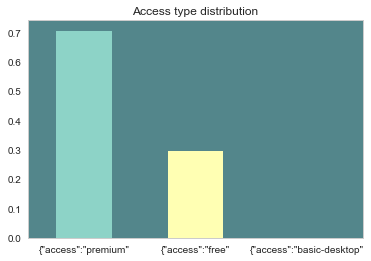

In [7]:
plt.title('Access type distribution')
(users['access'].value_counts() / users.shape[0]).plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

### Gender

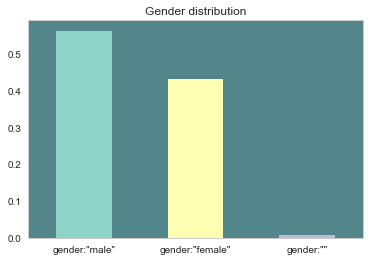

In [8]:
plt.title('Gender distribution')
(users['gender'].value_counts() / users.shape[0]).plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

### Country

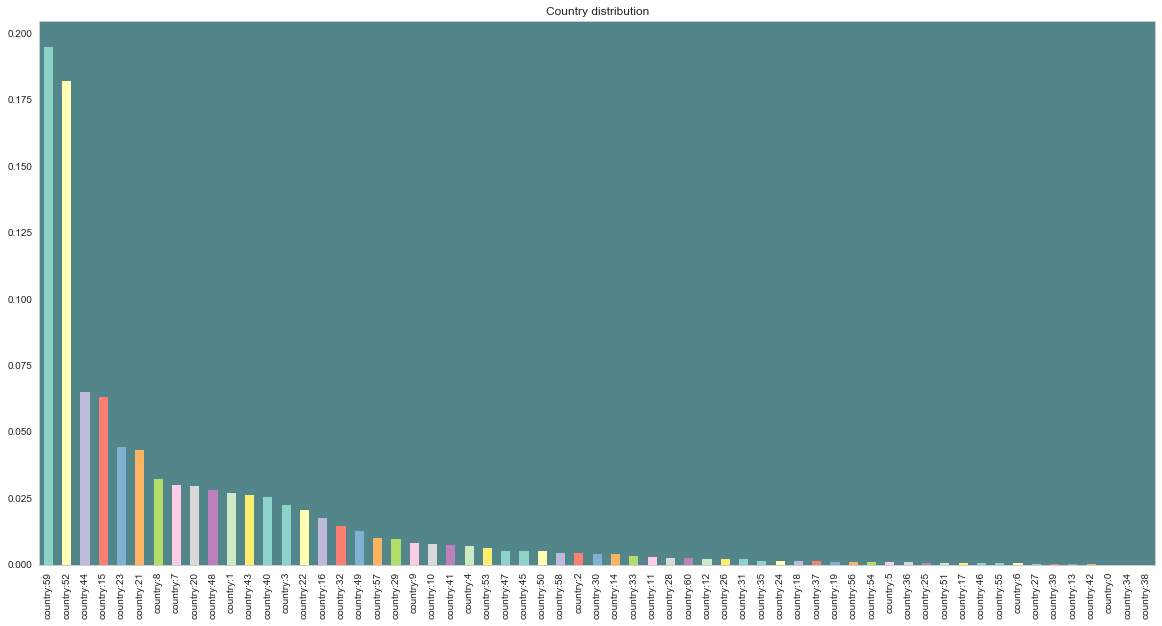

In [9]:
plt.title('Country distribution')
(users['country'].value_counts() / users.shape[0]).plot(kind = 'bar', figsize  = (20, 10))
plt.xticks(rotation = 90)
plt.show()

In [10]:
users[users['country'].isin(users['country'].value_counts().index[:4])].shape[0] / users.shape[0], \
users['country'].value_counts().index[:4].tolist()

(0.505024734919083, ['country:59', 'country:52', 'country:44', 'country:15'])

In [11]:
top_countries = users['country'].value_counts().index[:4].tolist()

### Age

In [12]:
users['birth_year'] = users['birth_year'].map(lambda x: clean_text(x , 'numbers')).replace('', '2000').astype(int)

In [13]:
users['age'] = 2018 - users['birth_year']

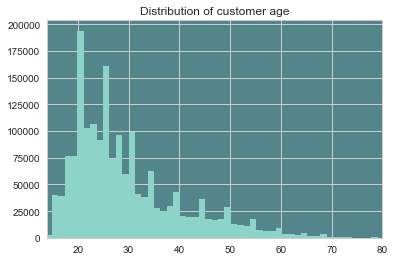

In [14]:
plt.title('Distribution of customer age')
ax = users['age'].hist(bins = 100)
ax.set_xlim(14, 80)
plt.show()

### Age and gender

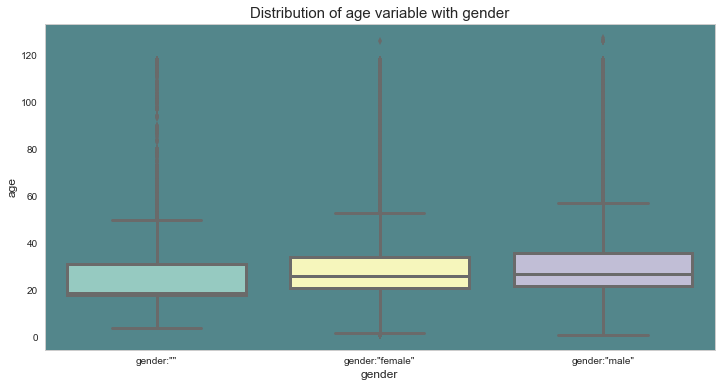

In [15]:
x_name = 'gender'
y_name = 'age'
col_order = np.sort(users[x_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=x_name, y=y_name, data=users, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

### Age and access type

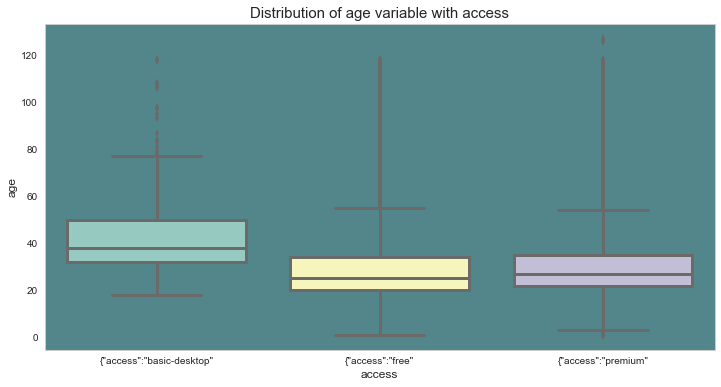

In [16]:
x_name = 'access'
y_name = 'age'
col_order = np.sort(users[x_name].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=x_name, y=y_name, data=users, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

### Age and country

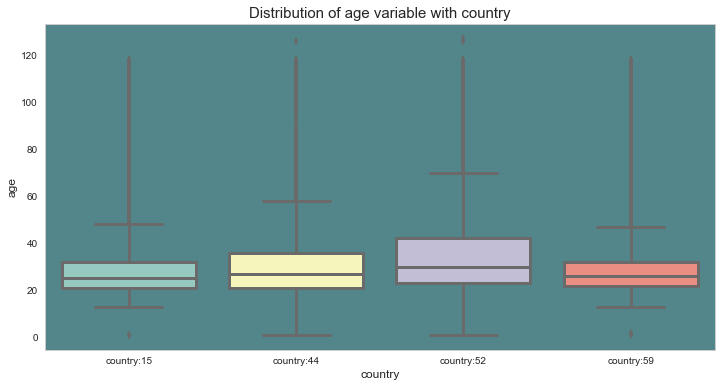

In [17]:
x_name = 'country'
y_name = 'age'
col_order = np.sort(top_countries).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=x_name, y=y_name, data=users[users['country'].isin(top_countries)], order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
plt.show()

# Tracks

In [18]:
import gzip
import json

tracks=gzip.open(path + 'tracks','rb')
tracks=tracks.read().decode().split('\n')

strings = []

counter = 0
for track in tracks:    
    line = json.loads(track)
    _ = []
    for key, value in line.items():
        _.append(key  + ' : ' + value)
    strings.append(_)

tracks = pd.DataFrame(strings)

In [19]:
# tracks = pd.read_csv(path + 'tracks', compression = 'gzip', quotechar = '"',
#                      header = None, error_bad_lines=False)
tracks.columns = ['album_artist', 'album_code', 'album_name', 'track_id', 'track_name']
tracks['track_id'] = tracks['track_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
tracks.head()

,album_artist,album_code,album_name,track_id,track_name
0,album_artist : Tasia Rojas,album_code : ece406c1937c4123e6b935f39898770dc...,album_name : Salmon Addition,fe2f34b55827b9721aa503d1dc9f3bca951859de,track_name : Doubtful Anteater
1,album_artist : Gertrude Faulkner,album_code : bb94c41eade59eeec79b04aa141c99344...,album_name : Newfoundland Quilt,2432c3346fc867e9026174ea73ab787a7fdeaa1f,track_name : Heartbreaking Louse
2,album_artist : Ora Corcoran,album_code : 0db473f623b01b0134f8178512f91e5ac...,album_name : Havanese Push,cb5e2409dfa5c9c8ccabdca2afeb6e84eca9a435,track_name : Watery Tortoise
3,album_artist : Shanika Wing,album_code : 4aadb443b1d8cc4c84a6ca1dd348c5993...,album_name : Puma Hate,2998e8ecabbf9d220dc22c516740f7982b2353e8,track_name : Nutritious Ox
4,album_artist : Lonnie Hope,album_code : a2b64056f39d60b0de18550d43a37b64b...,album_name : Kingfisher Garden,fb581ad122d260941757c5a2b1ed1a42108d632f,track_name : Foregoing Umbrellabird


In [20]:
tracks.shape

(83426, 5)

In [21]:
tracks.shape[0] == tracks['track_id'].nunique()

True

In [22]:
tracks.nunique()

album_artist    16915
album_code      24913
album_name      23201
track_id        83426
track_name      70979
dtype: int64

### Number of tracks per artist

Median value: 2.0


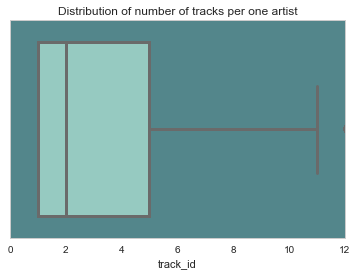

In [23]:
plt.title('Distribution of number of tracks per one artist')
print("Median value: %s" % tracks.groupby('album_artist')['track_id'].nunique().median())
ax = sns.boxplot(x=tracks.groupby('album_artist')['track_id'].nunique())
ax.set_xlim(0, 12)
plt.show()

### Number of albums per artist

Median value: 1.0


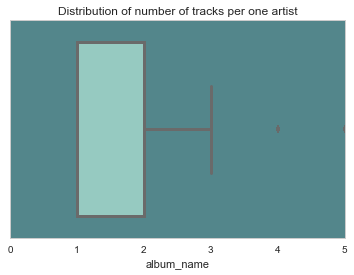

In [24]:
plt.title('Distribution of number of tracks per one artist')
print("Median value: %s" % tracks.groupby('album_artist')['album_name'].nunique().median())
ax = sns.boxplot(x=tracks.groupby('album_artist')['album_name'].nunique())
ax.set_xlim(0, 5)
plt.show()

### Number of tracks per album

Median value: 1.0


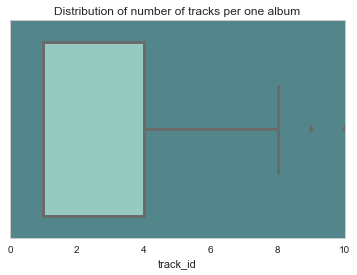

In [25]:
plt.title('Distribution of number of tracks per one album')
print("Median value: %s" % tracks.groupby('album_name')['track_id'].nunique().median())
ax = sns.boxplot(x=tracks.groupby('album_name')['track_id'].nunique())
ax.set_xlim(0, 10)
plt.show()

# Allcountries

In [26]:
allcountries = pd.read_csv(path + 'allcountries', compression = 'gzip', header = None, engine = 'python', quotechar="'", error_bad_lines=False)
allcountries.columns = ['device_type', 'length', 'os', 'timestamp', 'track_id', 'user_id']
allcountries['user_id'] = allcountries['user_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
allcountries['track_id'] = allcountries['track_id'].map(lambda x: x.split(':')[1].replace("{", "").replace("}", "").strip('"'))
allcountries.head()

,device_type,length,os,timestamp,track_id,user_id
0,"{""device_type"":""mobile""","""length"":136","""os"":""iOS""","""timestamp"":1504923300000",c43ac11b86c603e40aad9a0fbe72d192c0c51ded,3db57275059923d98119850a6233d3c609a171a5
1,"{""device_type"":""desktop""","""length"":60","""os"":""Browser""","""timestamp"":1504951200000",eee087bddc7db49cde2d43df7a04f3975dff4a78,0495eb11e3ca80c0289d3a08b5c60f0227e12314
2,"{""device_type"":""mobile""","""length"":191","""os"":""iOS""","""timestamp"":1504944900000",45e8fe7c02519b99b9284717cd3488eab2ef798e,b3d9fb538674878162e5a93566195daf878723db
3,"{""device_type"":""desktop""","""length"":268","""os"":""other""","""timestamp"":1504980900000",eb1016ee12dc5a3ada044b7dacb716049ed121c8,4831658d8f436e8c6ecf29984c405521de26e654
4,"{""device_type"":""mobile""","""length"":212","""os"":""Android""","""timestamp"":1504916100000",863af142e7604488cfd8f2245b65c9e6cafcd201,e1a1bb65848f54f266273caad9a327d13397889f


In [27]:
allcountries.shape

(4313582, 6)

In [28]:
allcountries.shape[0] == allcountries['track_id'].nunique(), allcountries.shape[0] == allcountries['user_id'].nunique()

(False, False)

In [29]:
allcountries.nunique()

device_type          3
length             870
os                   8
timestamp           96
track_id         83426
user_id        1787756
dtype: int64

### Streams by OS

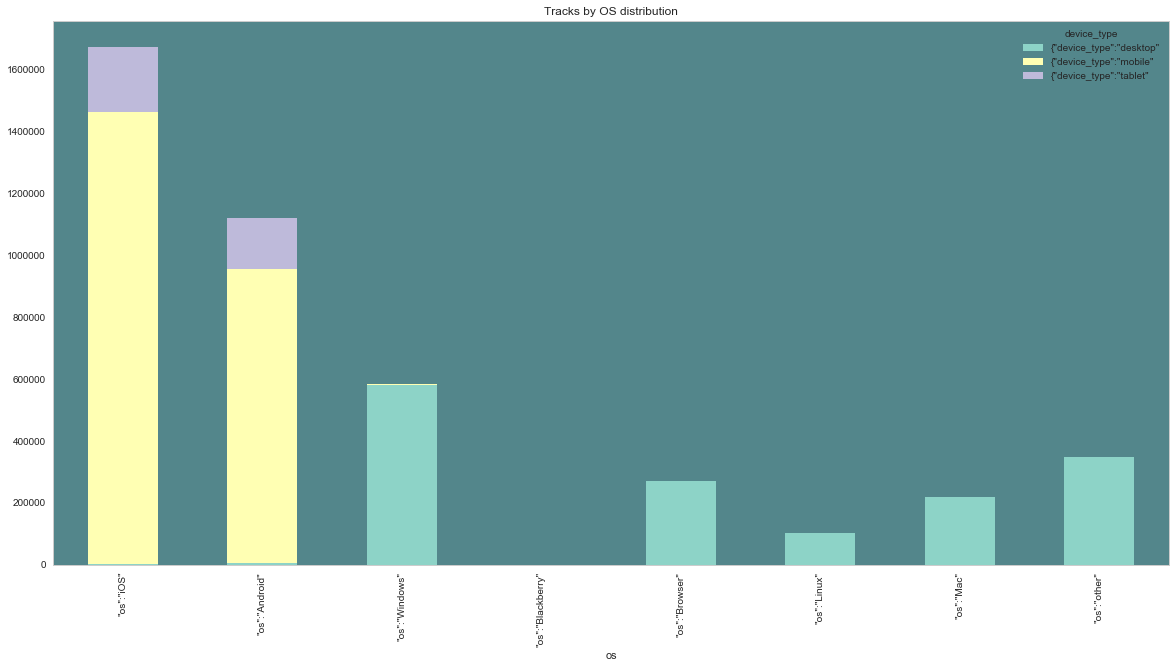

In [30]:
s = allcountries.groupby(['os', 'device_type']).size().reset_index().pivot(columns='device_type', index='os', values=0).fillna(0)
s.sort_values(by = ['{"device_type":"mobile"'], ascending = False).plot(kind='bar', stacked=True, figsize = (20, 10))
plt.title('Tracks by OS distribution')
plt.xticks(rotation = 90)
plt.show()

### Users by OS

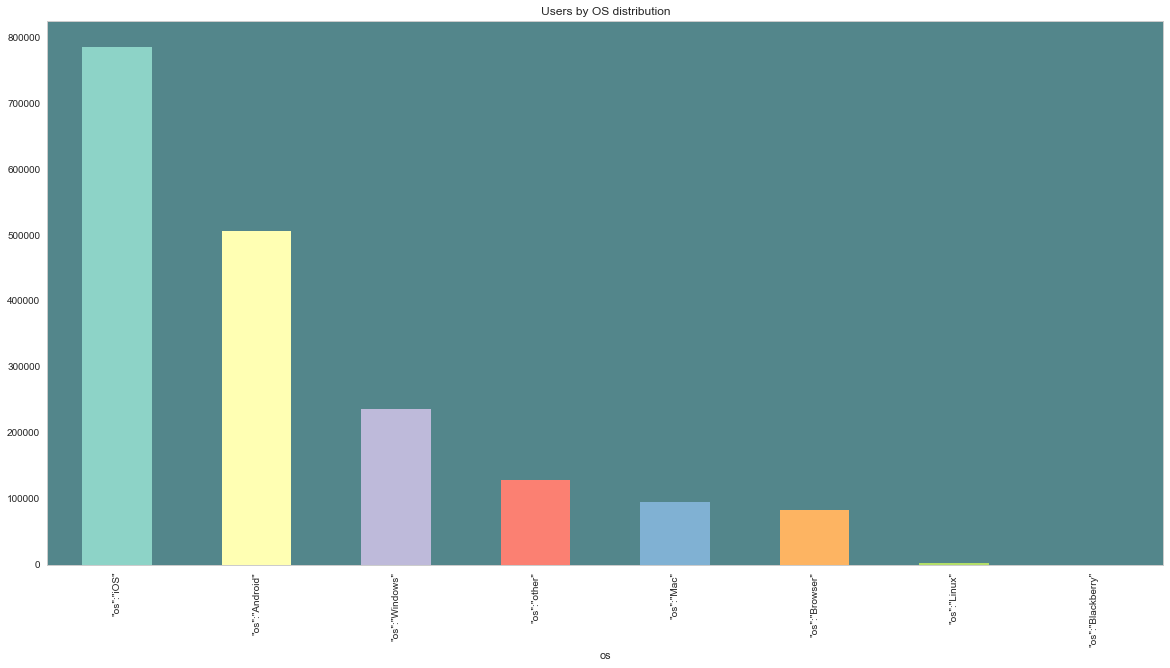

In [31]:
plt.title('Users by OS distribution')
allcountries.groupby('os')['user_id'].nunique().sort_values(ascending = False).plot(kind = 'bar', figsize  = (20, 10))
plt.xticks(rotation = 90)
plt.show()

### Tracks by OS

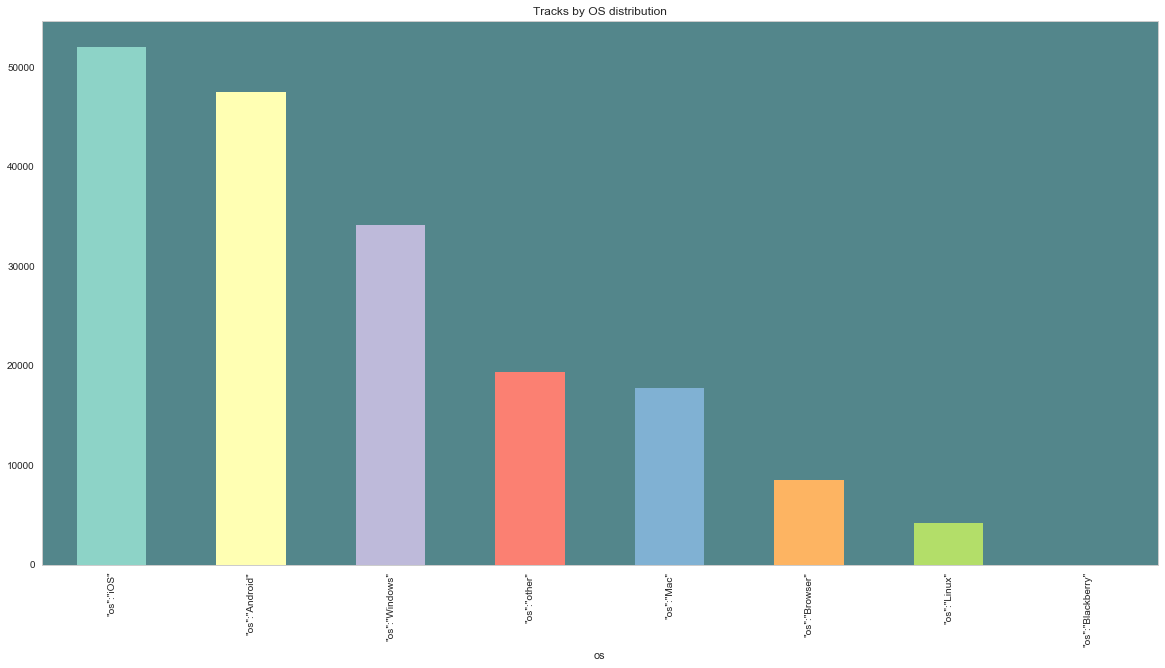

In [32]:
plt.title('Tracks by OS distribution')
allcountries.groupby('os')['track_id'].nunique().sort_values(ascending = False).plot(kind = 'bar', figsize  = (20, 10))
plt.xticks(rotation = 90)
plt.show()

### Distribution of streams per user

Median value: device_type
{"device_type":"desktop"   160,566.50
{"device_type":"mobile"          0.50
{"device_type":"tablet"          0.00
dtype: float64


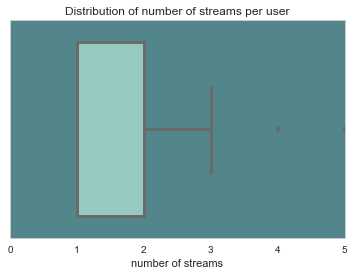

In [33]:
plt.title('Distribution of number of streams per user')
user_track_count = allcountries.groupby('user_id')['track_id'].count()
print("Median value: %s" % s.median())
ax = sns.boxplot(x=user_track_count)
ax.set_xlim(0, 5)
plt.xlabel('number of streams')
plt.show()

#### Check if we have some suspicious outliers (extreme number of streams)

In [34]:
user_track_count.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99, .999])

count   1,787,756.00
mean            2.41
std            13.47
min             1.00
1%              1.00
10%             1.00
20%             1.00
30%             1.00
40%             1.00
50%             1.00
60%             1.00
70%             2.00
80%             2.00
90%             4.00
99%            16.00
99.9%          86.00
max         3,310.00
Name: track_id, dtype: float64

#### Check how many users with streams more than 100

In [35]:
print("There are only %s users with number of streams more then 100" % user_track_count[user_track_count > 100].shape[0])

There are only 1563 users with number of streams more then 100


#### Save statistics for further analysis

### Distribution of stream length

In [36]:
allcountries['length'] = allcountries['length'].map(lambda x: clean_text(x , 'numbers')).astype(int)

Median value: 172.0


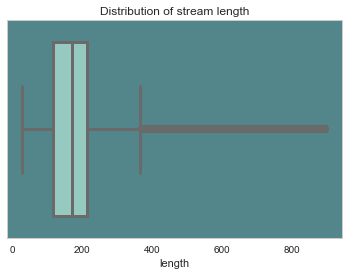

In [37]:
plt.title('Distribution of stream length')
print("Median value: %s" % allcountries['length'].median())
ax = sns.boxplot(x=allcountries['length'])
# ax.set_xlim(0, 10)
plt.show()

#### Check if we have some suspicious outliers (extreme length of streams)

In [38]:
allcountries.describe()

,length
count,"4,313,582.00"
mean,172.80
std,88.65
min,30.00
25%,116.00
50%,172.00
75%,216.00
max,900.00


### DIstribution of number of devices per user

Median value: 1.0


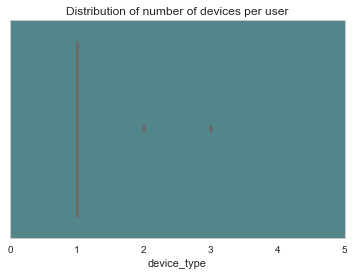

In [39]:
plt.title('Distribution of number of devices per user')
s = allcountries.groupby('user_id')['device_type'].nunique()
print("Median value: %s" % s.median())
ax = sns.boxplot(x=s)
ax.set_xlim(0, 5)
plt.show()

### Distribution of track length for different OS

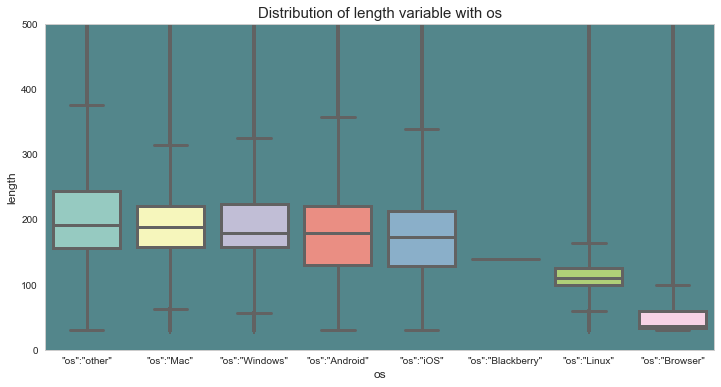

In [40]:
x_name = 'os'
y_name = 'length'
col_order = allcountries.groupby(x_name)[y_name].mean().sort_values(ascending = False).index.tolist()
plt.figure(figsize=(12,6))
ax = sns.boxplot(x=x_name, y=y_name, data=allcountries, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
ax.set_ylim(0, 500)
plt.show()

### Distribution of track length for different device types

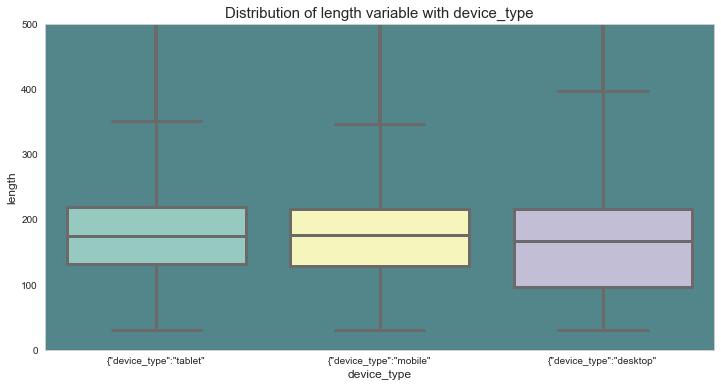

In [41]:
x_name = 'device_type'
y_name = 'length'
col_order = allcountries.groupby(x_name)[y_name].mean().sort_values(ascending = False).index.tolist()
plt.figure(figsize=(12,6))
ax = sns.boxplot(x=x_name, y=y_name, data=allcountries, order=col_order)
plt.xlabel(x_name, fontsize=12)
plt.ylabel(y_name, fontsize=12)
plt.title("Distribution of %s variable with %s" % (y_name, x_name), fontsize=15)
ax.set_ylim(0, 500)
plt.show()

### Distribution of gap between streams for users

In [42]:
allcountries = allcountries.sort_values(by = ['user_id', 'timestamp'])
allcountries['timestamp'] = allcountries['timestamp'].map(lambda x: clean_text(x , 'numbers')).astype(float)
allcountries['timestamp_previous'] = allcountries.groupby('user_id', sort = False)['timestamp'].shift(1)
allcountries['gap'] = allcountries['timestamp'] - allcountries['timestamp_previous']

# convert gaps tp days units
allcountries['gap'] = allcountries['gap'] / (24*3600)

In [43]:
allcountries[allcountries['gap'].notnull()]['gap'].describe()

count   2,525,826.00
mean           55.26
std           120.64
min             0.00
25%             0.00
50%            10.42
75%            41.67
max           989.58
Name: gap, dtype: float64

Median value: 1 days


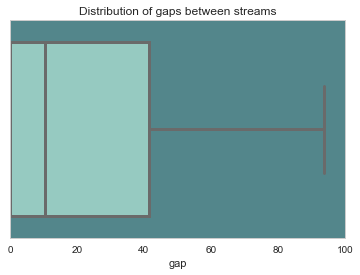

In [44]:
plt.title('Distribution of gaps between streams')
user_gap_stat = allcountries[allcountries['gap'].notnull()]['gap']
print("Median value: %s days" % int(s.median()))
ax = sns.boxplot(x=user_gap_stat)
ax.set_xlim(0, 100)
plt.show()

In [45]:
user_gap_stat.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99, .999])

count   2,525,826.00
mean           55.26
std           120.64
min             0.00
1%              0.00
10%             0.00
20%             0.00
30%             0.00
40%             0.00
50%            10.42
60%            10.42
70%            31.25
80%            72.92
90%           166.67
99%           635.42
99.9%         895.83
max           989.58
Name: gap, dtype: float64

### Dependency between stream length and gap between streams

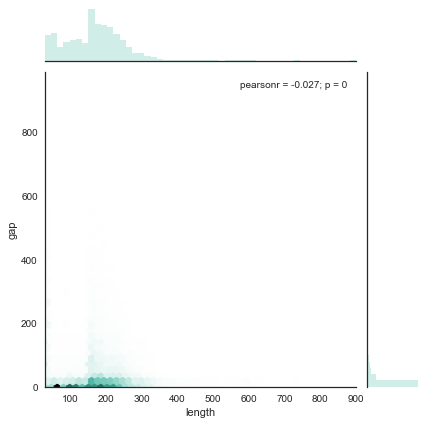

In [46]:
with sns.axes_style('white'):
    sns.jointplot("length", "gap", allcountries, kind='hex')

### Dependency between stream length and number of streams

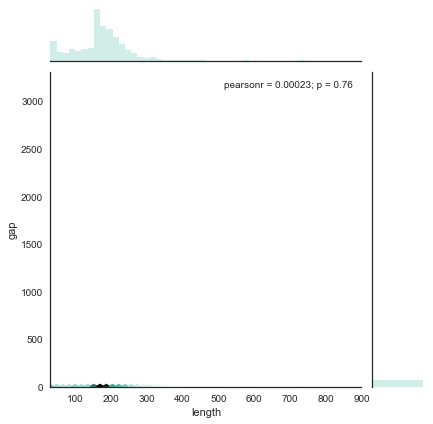

In [47]:
s  = allcountries.groupby('user_id')["length", "gap"].agg({'length' : 'mean', 'gap' : 'count'}).reset_index()
with sns.axes_style('white'):
    sns.jointplot("length", "gap", s, kind='hex')